In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from model import OrthogonalAutoEncoder
from training import TrainingModel
from utils import create_grouped_bar_plot
from gradients import get_integrated_gradients, get_integrated_gradients_mc

In [2]:
# AI4I (data from https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)
# only keeping columns: Air_temperature, Process_temperature, Rotational_speed, Torque, Tool_wear, y
df = pd.read_csv("/Users/dcac/Data/ai4i/ai4i2020_reduced.csv").iloc[:1000, 3:]
df_train = df[df["y"] == 0].drop(["y"], axis=1)  # clean training data to fit the model
df_test = df[df["y"] == 1].drop(["y"], axis=1)

In [3]:
df.columns

Index(['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque',
       'Tool_wear', 'y'],
      dtype='object')

In [4]:
# Scaling data
scaler = StandardScaler()
x1 = torch.Tensor(pd.DataFrame(scaler.fit_transform(df_train)).values)
x2 = torch.Tensor(pd.DataFrame(scaler.transform(df_train)).values)

In [5]:
# Initiating model
model = OrthogonalAutoEncoder(encoding_layers=[5, 5], activation_function=nn.ReLU(), dropout=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
sum(p.numel() for p in model.parameters() if p.requires_grad)  # number of parameters

OrthogonalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


80

In [6]:
# Training model (validation loss is lower because of dropout)
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
train = TrainingModel(penalty=0.1, learning_rate=1e-3, batch_size=20, val_size=0.20, verbose=True)
train_loader, valid_loader = train.create_datasets(train_data=x1)
trained_model, losses = train.train_model(model, patience=10, n_epochs=1000)

[   1/1000] train_loss: 13.011637 valid_loss: 10.834707
Validation loss decreased (inf --> 10.834707).  Saving model ...
[   2/1000] train_loss: 10.445518 valid_loss: 19.395362
EarlyStopping counter: 1 out of 10
[   3/1000] train_loss: 8.667112 valid_loss: 17.341074
EarlyStopping counter: 2 out of 10
[   4/1000] train_loss: 7.301068 valid_loss: 10.358054
Validation loss decreased (10.834707 --> 10.358054).  Saving model ...
[   5/1000] train_loss: 6.281290 valid_loss: 4.759907
Validation loss decreased (10.358054 --> 4.759907).  Saving model ...
[   6/1000] train_loss: 5.444120 valid_loss: 8.355555
EarlyStopping counter: 1 out of 10
[   7/1000] train_loss: 4.689981 valid_loss: 7.105085
EarlyStopping counter: 2 out of 10
[   8/1000] train_loss: 4.092471 valid_loss: 5.637717
EarlyStopping counter: 3 out of 10
[   9/1000] train_loss: 3.740627 valid_loss: 3.196633
Validation loss decreased (4.759907 --> 3.196633).  Saving model ...
[  10/1000] train_loss: 3.248955 valid_loss: 3.667928
Earl

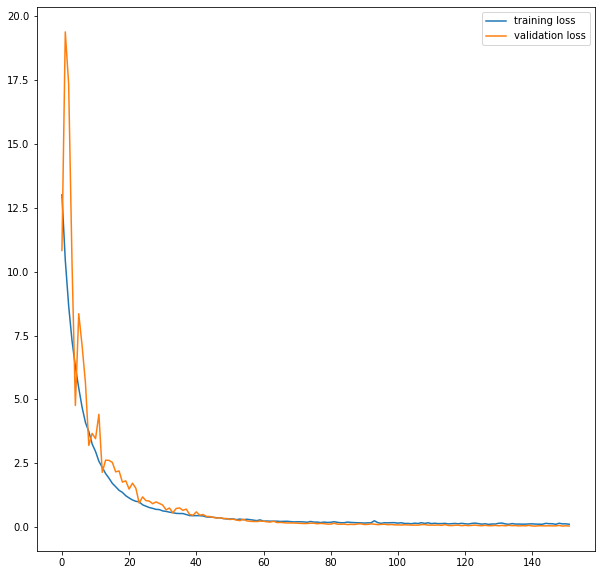

In [7]:
# Plot losses
plt.figure(figsize=(10, 10))
plt.plot(losses["train"], label="training loss")
plt.plot(losses["val"], label="validation loss")
plt.legend()
plt.show()

In [8]:
# Saving trained model
torch.save(trained_model, "orthogonal_autoencoder.pt")

In [9]:
# Computing integrated gradients of the encoder network
base = x1.mean(axis=0)
example = x2[0]
int_grads_tr, _ = get_integrated_gradients(model=trained_model, inp=example, baseline=base, steps=20)
int_grads_mc, _ = get_integrated_gradients_mc(model=trained_model, inp=example, baseline=base, samples=100)

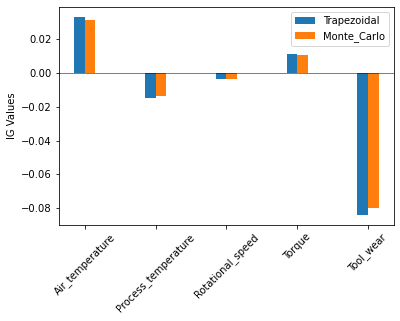

In [10]:
# Plotting integrated gradients
create_grouped_bar_plot(df_train.columns, Trapezoidal=int_grads_tr, Monte_Carlo=int_grads_mc)